# Multi Modal Sentiment and Emotional Analytics

In [1]:
import os
import zipfile

# Extract dataset
zip_path = "/content/fer2013.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("fer2013")

# Confirm extraction
print("Extracted files:", os.listdir("fer2013"))


Extracted files: ['train', 'test']


In [2]:
# Extract dataset
zip_path = "/content/sentiment140.zip"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall("sentiment140")

# Confirm extraction
print("Extracted files:", os.listdir("sentiment140"))

Extracted files: ['training.1600000.processed.noemoticon.csv']


In [3]:
import pandas as pd
import re
import string

# Load Sentiment140 dataset
csv_path = "/content/sentiment140/training.1600000.processed.noemoticon.csv"
df = pd.read_csv(csv_path, encoding='ISO-8859-1', header=None)



In [4]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.columns = ["sentiment", "id", "date", "query", "user", "text"]
df = df[["sentiment", "text"]]  # Keep relevant columns

# Convert sentiment labels (0 → Negative, 4 → Positive)
df["sentiment"] = df["sentiment"].replace({0: "Negative", 4: "Positive"})


In [6]:
# Clean text
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = text.translate(str.maketrans("", "", string.punctuation))
    return text

df["clean_text"] = df["text"].apply(clean_text)
df.head()


,sentiment,text,clean_text
0,Negative,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",switchfoot awww thats a bummer you shoulda ...
1,Negative,is upset that he can't update his Facebook by ...,is upset that he cant update his facebook by t...
2,Negative,@Kenichan I dived many times for the ball. Man...,kenichan i dived many times for the ball manag...
3,Negative,my whole body feels itchy and like its on fire,my whole body feels itchy and like its on fire
4,Negative,"@nationwideclass no, it's not behaving at all....",nationwideclass no its not behaving at all im ...


Available images: ['Training_78618955.jpg', 'Training_65042094.jpg', 'Training_15471955.jpg', 'Training_69342045.jpg', 'Training_13124370.jpg']


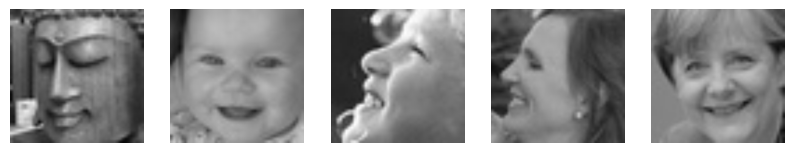

In [7]:
import os
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Define image path
image_folder = "/content/fer2013/train/happy"

# Confirm image path
if os.path.exists(image_folder):
    print("Available images:", os.listdir(image_folder)[:5])  # Show some file names
else:
    print("Error: Image folder not found!")

# Load images
image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith(('.jpg', '.png'))][:10]

# Define transformations
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# Apply transformation
images = [transform(Image.open(img)) for img in image_files]

# Display images
fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, img in enumerate(images[:5]):
    axes[i].imshow(img.permute(1, 2, 0).numpy())
    axes[i].axis("off")
plt.show()


In [24]:
# Emotion Classification using pre trained CNN
import torch
from torchvision import models, transforms
from PIL import Image

# 1. Load ResNet18 with FER2013-compatible modifications
model = models.resnet18(pretrained = True)  # Start with untrained weights
# Adjust the final fully connected layer for 7 classes (FER2017)
model.fc = torch.nn.Linear(model.fc.in_features, 7)
model.eval()

# 3. Define transformations matching your training preprocessing
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  # ResNet expects 3 channels
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

# 4. Predict on a single example image
image = Image.open("fer2013/test/happy/PrivateTest_10470092.jpg")
image = transform(image).unsqueeze(0)  # Add batch dimension

with torch.no_grad():
    output = model(image)
    prediction = torch.argmax(output, dim=1).item()

# 5. Map prediction to emotion
emotions = ["Angry", "Disgust", "Fear", "Happy", "Neutral", "Sad" , "Surprise"]
print("Predicted Emotion:", emotions[prediction])


Predicted Emotion: Happy


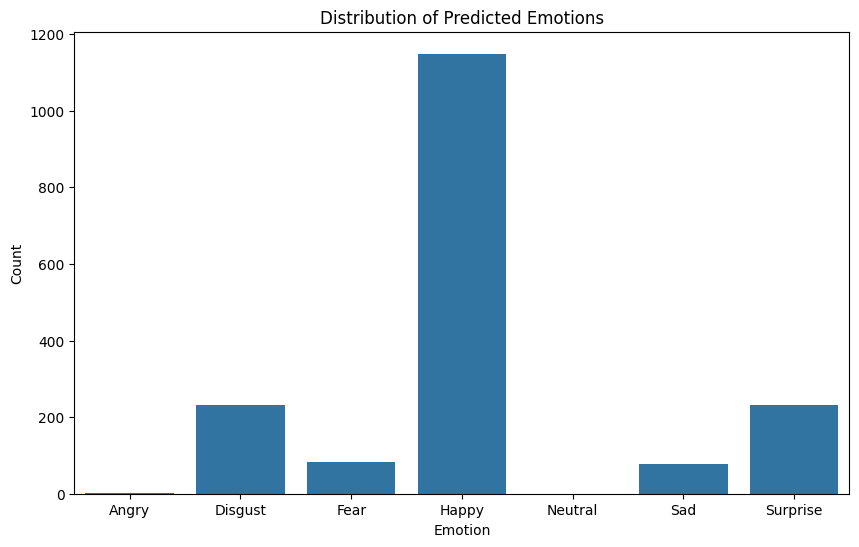

In [25]:
import os
import seaborn as sns
import matplotlib.pyplot as plt

#  Classify a batch of images
image_folder = "fer2013/test/happy"
predictions = []

for image_name in os.listdir(image_folder):
    image_path = os.path.join(image_folder, image_name)
    image = Image.open(image_path)
    image = transform(image).unsqueeze(0)  # Add batch dimension

    with torch.no_grad():
        output = model(image)
        prediction = torch.argmax(output, dim=1).item()
        predictions.append(emotions[prediction])

#  Visualize the distribution of predicted emotions
plt.figure(figsize=(10, 6))
sns.countplot(x=predictions, order=emotions)
plt.title('Distribution of Predicted Emotions')
plt.xlabel('Emotion')
plt.ylabel('Count')
plt.show()

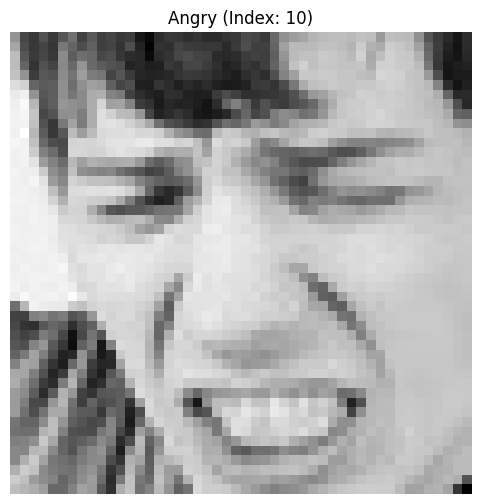

In [15]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Set path to test folder
test_dir = "/content/fer2013/test"
emotion = "angry"
image_index = 10

# Construct full path to specific image
emotion_dir = os.path.join(test_dir, emotion)
image_files = sorted(os.listdir(emotion_dir))
specific_image = os.path.join(emotion_dir, image_files[image_index])

# Display the image
img = mpimg.imread(specific_image)
plt.figure(figsize=(6, 6))
plt.imshow(img, cmap='gray')
plt.title(f"{emotion.capitalize()} (Index: {image_index})")
plt.axis('off')
plt.show()

In [11]:
# Text Sentiment Analysis with Hugging Face

from transformers import pipeline

# Load a Twitter-specific model (3-class: negative, neutral, positive)
classifier = pipeline(
    "sentiment-analysis",
)

batch_size = 128
df_sample = df.sample(n=10_000, random_state=42).copy()
predictions = classifier(df_sample["clean_text"].tolist(), batch_size=128)

# Extract labels and scores
df_sample["predicted_label"] = [pred["label"].lower() for pred in predictions]
df_sample["confidence"] = [pred["score"] for pred in predictions]



No model was supplied, defaulted to distilbert/distilbert-base-uncased-finetuned-sst-2-english and revision 714eb0f (https://huggingface.co/distilbert/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

Device set to use cuda:0


In [12]:
df_sample.head()

,sentiment,text,clean_text,predicted_label,confidence
541200,Negative,@chrishasboobs AHHH I HOPE YOUR OK!!!,chrishasboobs ahhh i hope your ok,positive,0.996594
750,Negative,"@misstoriblack cool , i have no tweet apps fo...",misstoriblack cool i have no tweet apps for ...,positive,0.983419
766711,Negative,@TiannaChaos i know just family drama. its la...,tiannachaos i know just family drama its lame...,negative,0.995727
285055,Negative,School email won't open and I have geography ...,school email wont open and i have geography s...,negative,0.963292
705995,Negative,upper airways problem,upper airways problem,negative,0.999022


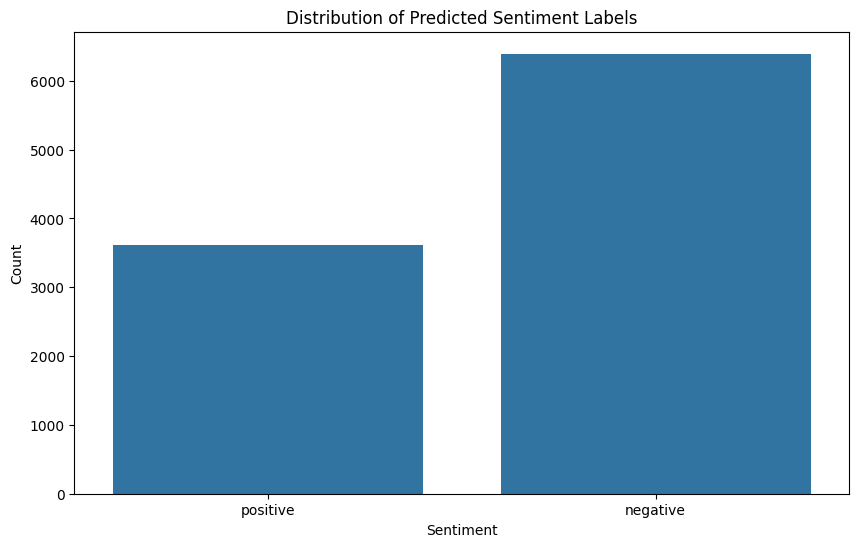

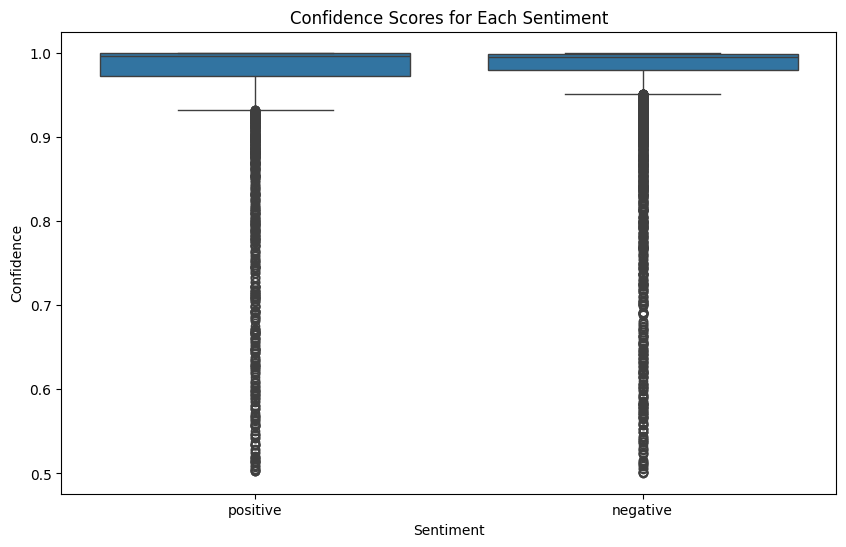

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

# Plot the distribution of predicted labels
plt.figure(figsize=(10, 6))
sns.countplot(x='predicted_label', data=df_sample)
plt.title('Distribution of Predicted Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

# Plot the confidence scores for each sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(x='predicted_label', y='confidence', data=df_sample)
plt.title('Confidence Scores for Each Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Confidence')
plt.show()

# Interactive visualization using Plotly
fig = px.scatter(df_sample, x='confidence', y='predicted_label', color='predicted_label',
                 title='Confidence Scores for Predicted Sentiments',
                 labels={'confidence': 'Confidence Score', 'predicted_label': 'Predicted Sentiment'})
fig.show()